___

<a href='http://www.pieriandata.com'> <img src='../../pierian_data.jpeg' /></a>
___

# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [161]:
train = pd.read_csv('titanic_train.csv')

In [162]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [163]:
train.isnull()  # The isnull method run against our df (train) will output true where we are missing values e.g NaN and false otheriwse.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


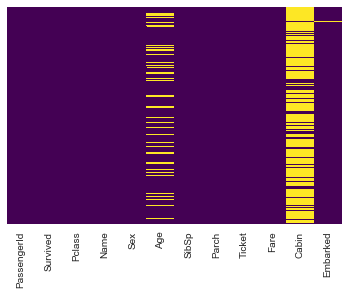

In [164]:
# We can use the isnull output above to plot a heatmap to better visualize it. Each yellow tick represents missing data. So for age col we have plenty of missing data, embarked just a row and the bulk being in the cabin col.
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

In [165]:
sns.set_style('whitegrid')  # Plot canvas style

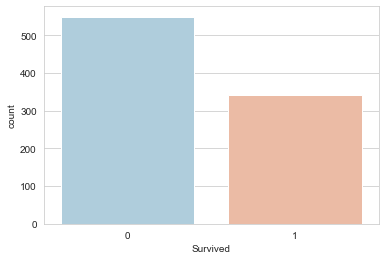

In [166]:
sns.countplot(x='Survived', data=train, palette='RdBu_r')

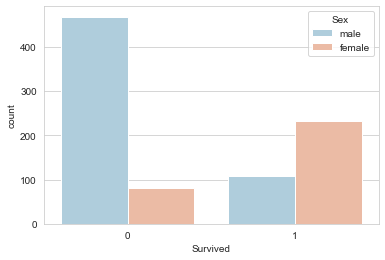

In [167]:
sns.countplot(x='Survived', hue='Sex', data=train, palette='RdBu_r') # Splits above plot into male & female composition

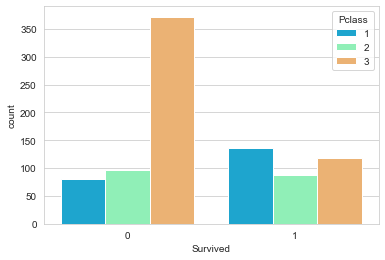

In [168]:
sns.countplot(x='Survived', hue='Pclass', data=train, palette='rainbow') # Split survived vs not into class

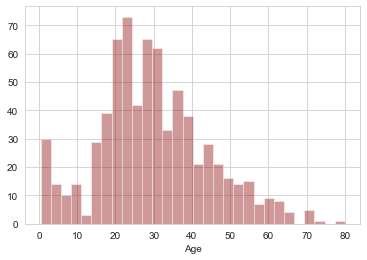

In [169]:
# A distribution plot of the age classes on-board (use panda .dropna() method to skip NaN values in the plot)
sns.distplot(train['Age'].dropna(), kde=False, color='darkred', bins=30)

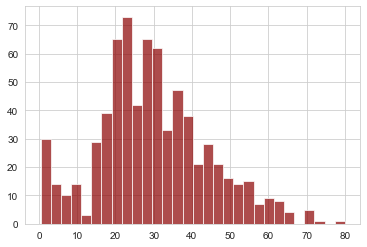

In [170]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7) # a pandas plot fo the above

In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


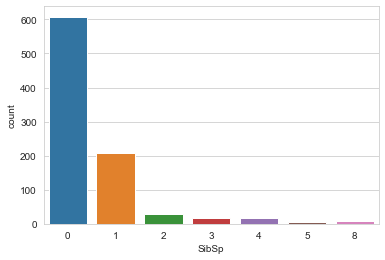

In [172]:
sns.countplot(x='SibSp', data=train) # Most people on-board did not have a child or spouse

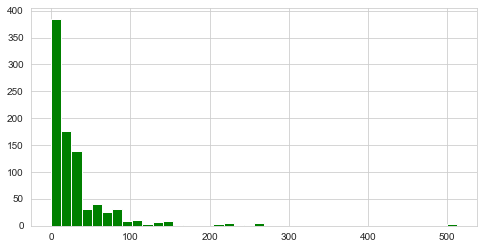

In [173]:
train['Fare'].hist(color='green', bins=40, figsize=(8,4))

____
### Cufflinks for plots
___
 Let's take a quick moment to show an interactive plot using cufflinks!

In [174]:
import cufflinks as cf
cf.go_offline()

In [175]:
train['Fare'].iplot(kind='hist', bins=30, color='green')

___
## Data Cleaning
- We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling (imputation) in the mean age of all the passengers.  
- However we can be smarter about this and check the average age by passenger class and fill this in instead of of just filling in th eaverage age for all passengers.

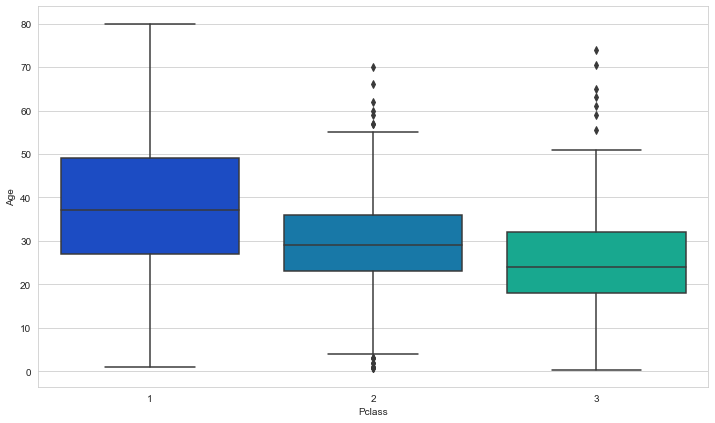

In [176]:
# A boxplot to visualize the average age per class (Pclass)
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass', y='Age', data=train, palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [177]:
# A function to determine the av age based on the passenger class for missing age data imputation
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37 # Compute using Pandas

        elif Pclass == 2:
            return 29 # Compute using Pandas

        else:
            return 24 # Compute using Pandas

    else:
        return Age

Now apply that function!

In [178]:
# Apply the above function to a sub-dataframe of train consisting of the age & Pclass col only.
train['Age'] = train[['Age','Pclass']].apply(impute_age, axis=1)

Now let's check that heat map again!

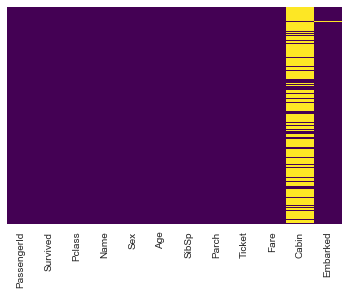

In [179]:
# Plot the heatmap from above again on train to see if we remedied the missing age values
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [180]:
train.drop('Cabin', axis=1, inplace=True)

In [181]:
train.dropna(inplace=True) # Drop any other NaN values e.g the missing 'Embarked' value

In [182]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Converting Categorical Features 

We'll need to convert categorical features e.g 'Sex' denoted as string (male/female) or 'Embarked' to dummy variables e.g 0 or 1 (denoted an 'OR') using pandas, otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [183]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [184]:
# Use the pandas get_dummies method to create df of with dummy variables. The se df created will have both complementary values for both Male and female i.e for each row if male is 1, then automatically female is 0. This can cause aproblem called multi-linearity (where on value cna be used to predic the other).
sex = pd.get_dummies(train['Sex'])
sex.head()

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [185]:
# To avoid the above problem, we drop one of the columns.
sex = pd.get_dummies(train['Sex'], drop_first=True)
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [186]:
# Lets do the above process for the embarked col (We avoid the muli-linearity problem by dropping one col to make 2 out of 3)
embark = pd.get_dummies(train['Embarked'], drop_first=True)
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [187]:
train = pd.concat([train, sex, embark], axis=1) # add the new cols to the train df

In [188]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


In [189]:
train.drop(['Sex','Embarked','Name','Ticket', 'PassengerId'], axis=1, inplace=True) # drop the col that we dont need anymore
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model! All data is numerical and ready for the logistic regression algorithm.  
NOTE THE PCLASS COL IS A CATEGORICAL COL AND CAN ONLY TAKE 3 VALUES.  THIS MEASN WE CAN ADD DUMMY VARIABLE FOR THIS COL AS WELL AND WILL IMPACT THE MACHINE LEARNING MODEL IF USED AS IS OR CONVERTED TO DUMMY VARIABLES.

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [199]:
# create the features / values cols used to predict (X) and the predictions cols (labels)
X = train.drop('Survived', axis=1)
y = train['Survived']

In [202]:
from sklearn.model_selection import train_test_split

In [203]:
# Method 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### Direct method of data splitting without creating the feature & label col first
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                     random_state=101)

## Training and Predicting

In [204]:
from sklearn.linear_model import LogisticRegression

In [205]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [206]:
predictions = logmodel.predict(X_test)

## Evaluation
We can check precision,recall,f1-score using classification report!

In [207]:
from sklearn.metrics import classification_report

In [209]:
print(classification_report(y_test, predictions))

precision    recall  f1-score   support

           0       0.80      0.91      0.85       163
           1       0.82      0.65      0.73       104

    accuracy                           0.81       267
   macro avg       0.81      0.78      0.79       267
weighted avg       0.81      0.81      0.80       267



In [211]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[148,  15],
       [ 36,  68]])

Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?

## Great Job!